# Tiny-ImageNet 图像分类实验

本实验在Tiny-ImageNet数据集上实验5个改进因子来提升图像分类性能。
实验流程与CIFAR-10实验完全一致，以验证改进因子在更复杂数据集上的表现。

## 实验设计

### 数据集特点
- **Tiny-ImageNet**: 100,000训练图像 + 10,000验证图像，64x64像素，200个类别
- 比CIFAR-10更复杂：更大的图像尺寸，更多的类别

### 5个改进因子（与CIFAR-10相同）
1. **残差连接** - 解决梯度消失问题
2. **更深/更宽的网络架构** - 增加模型容量
3. **更好的优化器和学习率调度** - 提升训练效果
4. **高级数据增强** - MixUp, CutMix
5. **注意力机制** - SE Attention

### 实验流程
1. 基线模型训练和评估
2. 逐个添加改进因子，记录性能变化
3. 分析每个因子的贡献
4. 组合最佳因子进行最终实验

In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import time
import os

# 导入自定义模块 - 使用TinyImageNet版本的models
from models_imagenet import get_model
from dataset_utils import get_dataset_loaders
from training_utils import (
    train_model, get_optimizer, get_scheduler, 
    get_optimizer_config, get_scheduler_config
)
from data_augmentation import get_transforms

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# ==================== 多GPU配置 ====================
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"检测到 {gpu_count} 个GPU:")
    for i in range(gpu_count):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device("cuda:0")
    use_multi_gpu = gpu_count > 1
else:
    device = torch.device("cpu")
    use_multi_gpu = False
    gpu_count = 1

print(f"\n主设备: {device}")
print(f"多GPU训练: {'启用' if use_multi_gpu else '未启用 (单卡/CPU)'}")

检测到 1 个GPU:
  GPU 0: NVIDIA RTX PRO 6000 Blackwell Server Edition

主设备: cuda:0
多GPU训练: 未启用 (单卡/CPU)


## 实验配置

In [2]:
# 实验配置
config = {
    'dataset': 'tiny_imagenet',
    'batch_size': 64 * gpu_count,  # 多GPU时每个GPU处理64张图像
    'num_workers': 4 * gpu_count,  # 多GPU时增加数据加载worker
    'num_epochs': 80,
    'print_every': 1,  # 这里print的是epoch
}

# 模型配置
models_to_test = [
    'baseline',          # 基线模型
    'residual',          # 改进因子(a): 残差连接
    'deeper_wider',      # 改进因子(b): 更深更宽网络
    'se_attention',      # 改进因子(e): SE注意力
]

# 优化器配置 - 改进因子(c)
optimizer_configs = {
    'Adam': {'optimizer': 'Adam', 'scheduler': None},
    'AdamW': {'optimizer': 'AdamW', 'scheduler': 'cosine'},
    'RMSprop': {'optimizer': 'RMSprop', 'scheduler': 'cosine'},
}

# 数据增强配置 - 改进因子(d)
augmentation_configs = {
    'basic': 'basic',
    'mixup': 'mixup',
    'cutmix': 'cutmix',
}

print("实验配置完成")
print(f"  - Batch Size: {config['batch_size']} ({'每GPU '+str(config['batch_size']//gpu_count) if use_multi_gpu else '单卡'})")
print(f"  - Num Workers: {config['num_workers']}")
print(f"  - Num Epochs: {config['num_epochs']}")

# ==================== 多GPU模型包装函数 ====================
def wrap_model_multi_gpu(model, use_multi_gpu=use_multi_gpu):
    """
    如果有多个GPU，将模型包装为DataParallel
    
    参数:
        model: 要包装的模型
        use_multi_gpu: 是否使用多GPU
    
    返回:
        包装后的模型
    """
    if use_multi_gpu:
        print(f"使用 DataParallel 在 {gpu_count} 个GPU上训练")
        model = nn.DataParallel(model)
    else:
        print(f"使用单设备训练")
    return model

实验配置完成
  - Batch Size: 64 (单卡)
  - Num Workers: 4
  - Num Epochs: 80


## 1. 基线模型实验

In [3]:
# 加载数据
train_loader, test_loader, num_classes = get_dataset_loaders(
    config['dataset'], 
    batch_size=config['batch_size'],
    num_workers=config['num_workers'],
    augmentation_type='basic'
)

print(f"数据集: {config['dataset']}")
print(f"类别数: {num_classes}")
print(f"训练集大小: {len(train_loader.dataset)}")
print(f"测试集大小: {len(test_loader.dataset)}")

数据集: tiny_imagenet
类别数: 200
训练集大小: 100000
测试集大小: 10000


In [4]:
# 基线模型实验
print("=== 基线模型实验 ===")

# 创建基线模型
baseline_model = get_model('baseline', num_classes)
baseline_model = wrap_model_multi_gpu(baseline_model)
baseline_model = baseline_model.to(device)

# 配置优化器
optimizer_config = get_optimizer_config('Adam')
optimizer = get_optimizer(baseline_model, 'Adam', **optimizer_config)

# 损失函数
criterion = nn.CrossEntropyLoss()

# 训练模型
baseline_history = train_model(
    baseline_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

baseline_acc = max(baseline_history['test_acc'])
print(f"\n基线模型最佳测试准确率: {baseline_acc:.2f}%")

# 保存结果
all_results = {'baseline': baseline_acc}

=== 基线模型实验 ===


使用单设备训练
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Server Edition)
模型参数量: 13.59M
Epoch   1/80: Train Loss: 5.1754, Train Acc: 0.94%, Test Loss: 5.0138, Test Acc: 2.17%, LR: 0.000300, Time: 19.77s
Epoch   2/80: Train Loss: 4.9540, Train Acc: 2.48%, Test Loss: 4.6981, Test Acc: 4.23%, LR: 0.000300, Time: 19.88s
Epoch   3/80: Train Loss: 4.7391, Train Acc: 4.21%, Test Loss: 4.5111, Test Acc: 6.31%, LR: 0.000300, Time: 19.73s
Epoch   4/80: Train Loss: 4.6032, Train Acc: 5.56%, Test Loss: 4.2928, Test Acc: 8.20%, LR: 0.000300, Time: 20.67s
Epoch   5/80: Train Loss: 4.4989, Train Acc: 6.75%, Test Loss: 4.2298, Test Acc: 9.19%, LR: 0.000300, Time: 19.57s
Epoch   6/80: Train Loss: 4.4103, Train Acc: 7.80%, Test Loss: 4.0263, Test Acc: 12.32%, LR: 0.000300, Time: 19.45s
Epoch   7/80: Train Loss: 4.3314, Train Acc: 8.74%, Test Loss: 3.9975, Test Acc: 12.40%, LR: 0.000300, Time: 19.60s
Epoch   8/80: Train Loss: 4.2650, Train Acc: 9.74%, Test Loss: 3.8132, Test Acc: 15.03%, LR: 0.000300, Tim

## 2. 改进因子实验

### 2.1 残差连接机制 (改进因子a)


In [5]:
print("=== 改进因子(a): 残差连接机制 ===")

# 创建带残差连接的模型
residual_model = get_model('residual', num_classes)
residual_model = wrap_model_multi_gpu(residual_model)
residual_model = residual_model.to(device)

# 使用相同的优化器配置
optimizer = get_optimizer(residual_model, 'Adam', **optimizer_config)

# 训练模型
residual_history = train_model(
    residual_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

residual_acc = max(residual_history['test_acc'])
all_results['residual'] = residual_acc
print(f"\n残差模型最佳测试准确率: {residual_acc:.2f}%")
print(f"相比基线提升: {residual_acc - baseline_acc:.2f}%")


=== 改进因子(a): 残差连接机制 ===
使用单设备训练
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Server Edition)
模型参数量: 9.91M


Epoch   1/80: Train Loss: 4.6455, Train Acc: 6.12%, Test Loss: 4.1841, Test Acc: 11.09%, LR: 0.000300, Time: 19.62s
Epoch   2/80: Train Loss: 4.0727, Train Acc: 12.84%, Test Loss: 3.7394, Test Acc: 17.19%, LR: 0.000300, Time: 19.22s
Epoch   3/80: Train Loss: 3.7633, Train Acc: 17.66%, Test Loss: 3.4253, Test Acc: 23.04%, LR: 0.000300, Time: 19.28s
Epoch   4/80: Train Loss: 3.5274, Train Acc: 21.73%, Test Loss: 3.3237, Test Acc: 25.46%, LR: 0.000300, Time: 19.41s
Epoch   5/80: Train Loss: 3.3514, Train Acc: 25.02%, Test Loss: 3.0349, Test Acc: 30.42%, LR: 0.000300, Time: 19.20s
Epoch   6/80: Train Loss: 3.2048, Train Acc: 27.54%, Test Loss: 2.9272, Test Acc: 32.15%, LR: 0.000300, Time: 19.11s
Epoch   7/80: Train Loss: 3.0886, Train Acc: 29.82%, Test Loss: 2.8149, Test Acc: 34.20%, LR: 0.000300, Time: 19.29s
Epoch   8/80: Train Loss: 2.9861, Train Acc: 31.65%, Test Loss: 2.7327, Test Acc: 36.37%, LR: 0.000300, Time: 19.14s
Epoch   9/80: Train Loss: 2.8989, Train Acc: 33.27%, Test Loss: 2

### 2.2 更深更宽的网络架构 (改进因子b)

In [6]:
print("=== 改进因子(b): 更深更宽的网络架构 ===")

# 创建更深更宽的模型
deeper_model = get_model('deeper_wider', num_classes)
deeper_model = wrap_model_multi_gpu(deeper_model)
deeper_model = deeper_model.to(device)

# 使用相同的优化器配置
optimizer = get_optimizer(deeper_model, 'Adam', **optimizer_config)

# 训练模型
deeper_history = train_model(
    deeper_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

deeper_acc = max(deeper_history['test_acc'])
all_results['deeper_wider'] = deeper_acc
print(f"更深更宽模型最佳测试准确率: {deeper_acc:.2f}%")
print(f"相比基线提升: {deeper_acc - baseline_acc:.2f}%")

=== 改进因子(b): 更深更宽的网络架构 ===
使用单设备训练
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Server Edition)
模型参数量: 19.45M
Epoch   1/80: Train Loss: 5.1790, Train Acc: 1.20%, Test Loss: 4.9795, Test Acc: 2.46%, LR: 0.000300, Time: 35.87s
Epoch   2/80: Train Loss: 4.9899, Train Acc: 2.15%, Test Loss: 4.7642, Test Acc: 3.51%, LR: 0.000300, Time: 35.99s
Epoch   3/80: Train Loss: 4.8206, Train Acc: 3.22%, Test Loss: 4.5289, Test Acc: 4.87%, LR: 0.000300, Time: 36.00s
Epoch   4/80: Train Loss: 4.6665, Train Acc: 4.52%, Test Loss: 4.3884, Test Acc: 6.83%, LR: 0.000300, Time: 36.12s
Epoch   5/80: Train Loss: 4.5612, Train Acc: 5.38%, Test Loss: 4.2990, Test Acc: 7.95%, LR: 0.000300, Time: 35.99s
Epoch   6/80: Train Loss: 4.4642, Train Acc: 6.63%, Test Loss: 4.1173, Test Acc: 9.94%, LR: 0.000300, Time: 35.86s
Epoch   7/80: Train Loss: 4.3725, Train Acc: 7.53%, Test Loss: 4.0260, Test Acc: 11.87%, LR: 0.000300, Time: 35.94s
Epoch   8/80: Train Loss: 4.2972, Train Acc: 8.44%, Test Loss: 4.0294, Test Acc:

### 2.3 调整优化器和学习率调度 (改进因子c)

In [7]:
print("=== 改进因子(c): 调整优化器和学习率调度 ===")

# 测试不同的优化器配置
optimizer_results = {}

for opt_name, opt_config in optimizer_configs.items():
    if opt_name == 'Adam':
        # Adam已经在基线实验中测试过了
        optimizer_results['Adam'] = baseline_acc
        print(f"Adam (baseline): {baseline_acc:.2f}%")
        continue
    
    print(f"测试优化器: {opt_name}")
    
    # 创建新模型
    model = get_model('baseline', num_classes)
    model = wrap_model_multi_gpu(model)
    model = model.to(device)
    
    # 配置优化器
    opt_config_dict = get_optimizer_config(opt_config['optimizer'])
    optimizer = get_optimizer(model, opt_config['optimizer'], **opt_config_dict)
    
    # 配置学习率调度器
    scheduler = None
    if opt_config['scheduler']:
        scheduler_config = get_scheduler_config(opt_config['scheduler'], config['num_epochs'])
        scheduler = get_scheduler(optimizer, opt_config['scheduler'], **scheduler_config)
    
    # 训练模型
    history = train_model(
        model, train_loader, test_loader,
        config['num_epochs'], optimizer, criterion, device,
        scheduler=scheduler, print_every=config['print_every']
    )
    
    best_acc = max(history['test_acc'])
    optimizer_results[opt_name] = best_acc
    all_results[opt_name] = best_acc
    print(f"{opt_name} 最佳测试准确率: {best_acc:.2f}%")

# 找到最佳优化器
best_optimizer = max(optimizer_results, key=optimizer_results.get)
print(f"最佳优化器: {best_optimizer} (准确率: {optimizer_results[best_optimizer]:.2f}%)")
print(f"相比基线提升: {optimizer_results[best_optimizer] - baseline_acc:.2f}%")

=== 改进因子(c): 调整优化器和学习率调度 ===
Adam (baseline): 31.36%
测试优化器: AdamW
使用单设备训练
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Server Edition)
模型参数量: 13.59M


Epoch   1/80: Train Loss: 5.1739, Train Acc: 1.06%, Test Loss: 5.0094, Test Acc: 2.29%, LR: 0.000300, Time: 19.36s
Epoch   2/80: Train Loss: 4.9759, Train Acc: 2.46%, Test Loss: 4.7015, Test Acc: 4.35%, LR: 0.000300, Time: 19.30s
Epoch   3/80: Train Loss: 4.7412, Train Acc: 4.21%, Test Loss: 4.4075, Test Acc: 6.82%, LR: 0.000299, Time: 19.31s
Epoch   4/80: Train Loss: 4.5951, Train Acc: 5.73%, Test Loss: 4.2998, Test Acc: 8.65%, LR: 0.000298, Time: 19.35s
Epoch   5/80: Train Loss: 4.4895, Train Acc: 6.84%, Test Loss: 4.2129, Test Acc: 9.86%, LR: 0.000297, Time: 19.27s
Epoch   6/80: Train Loss: 4.4038, Train Acc: 7.96%, Test Loss: 4.0252, Test Acc: 12.90%, LR: 0.000296, Time: 19.96s
Epoch   7/80: Train Loss: 4.3344, Train Acc: 8.86%, Test Loss: 3.9014, Test Acc: 14.26%, LR: 0.000294, Time: 19.37s
Epoch   8/80: Train Loss: 4.2698, Train Acc: 9.69%, Test Loss: 3.7960, Test Acc: 15.41%, LR: 0.000293, Time: 19.23s
Epoch   9/80: Train Loss: 4.2197, Train Acc: 10.37%, Test Loss: 3.7550, Test 

### 2.4 高级数据增强 (改进因子d)

In [8]:
print("=== 改进因子(d): 高级数据增强 ===")

# 测试不同的数据增强方法
augmentation_results = {}
augmentation_results['basic'] = baseline_acc  # 基线已经使用了basic augmentation

for aug_name, aug_type in augmentation_configs.items():
    if aug_name == 'basic':
        print(f"basic (baseline): {baseline_acc:.2f}%")
        continue  # baseline已经有了
    
    print(f"测试数据增强: {aug_name}")
    
    # 重新加载数据（使用不同的数据增强）
    train_loader_aug, test_loader_aug, _ = get_dataset_loaders(
        config['dataset'],
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        augmentation_type=aug_type
    )
    
    # 创建模型
    model = get_model('baseline', num_classes)
    model = wrap_model_multi_gpu(model)
    model = model.to(device)
    
    # 使用 Adam 优化器（与baseline一致）
    opt_config_dict = get_optimizer_config("Adam")
    optimizer = get_optimizer(model, "Adam", **opt_config_dict)
    
    # 训练模型
    history = train_model(
        model, train_loader_aug, test_loader_aug,
        config['num_epochs'], optimizer, criterion, device,
        augmentation=aug_type,
        print_every=config['print_every']
    )
    
    best_acc = max(history['test_acc'])
    augmentation_results[aug_name] = best_acc
    all_results[aug_name] = best_acc
    print(f"{aug_name} 最佳测试准确率: {best_acc:.2f}%")

# 找到最佳数据增强方法
best_augmentation = max(augmentation_results, key=augmentation_results.get)
print(f"最佳数据增强: {best_augmentation} (准确率: {augmentation_results[best_augmentation]:.2f}%)")
print(f"相比基线提升: {augmentation_results[best_augmentation] - baseline_acc:.2f}%")

=== 改进因子(d): 高级数据增强 ===
basic (baseline): 31.36%
测试数据增强: mixup
使用单设备训练
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Server Edition)
模型参数量: 13.59M
Epoch   1/80: Train Loss: 5.2195, Train Acc: 0.00%, Test Loss: 5.0535, Test Acc: 1.82%, LR: 0.000300, Time: 15.90s
Epoch   2/80: Train Loss: 5.1135, Train Acc: 0.00%, Test Loss: 4.7786, Test Acc: 4.53%, LR: 0.000300, Time: 15.87s
Epoch   3/80: Train Loss: 4.9834, Train Acc: 0.00%, Test Loss: 4.5265, Test Acc: 6.61%, LR: 0.000300, Time: 15.88s


Epoch   4/80: Train Loss: 4.8817, Train Acc: 0.00%, Test Loss: 4.3712, Test Acc: 8.27%, LR: 0.000300, Time: 15.90s
Epoch   5/80: Train Loss: 4.8270, Train Acc: 0.00%, Test Loss: 4.2230, Test Acc: 10.66%, LR: 0.000300, Time: 15.84s
Epoch   6/80: Train Loss: 4.7754, Train Acc: 0.00%, Test Loss: 4.1184, Test Acc: 11.94%, LR: 0.000300, Time: 15.67s
Epoch   7/80: Train Loss: 4.7347, Train Acc: 0.00%, Test Loss: 4.0294, Test Acc: 13.71%, LR: 0.000300, Time: 15.66s
Epoch   8/80: Train Loss: 4.7012, Train Acc: 0.00%, Test Loss: 4.0012, Test Acc: 14.21%, LR: 0.000300, Time: 15.75s
Epoch   9/80: Train Loss: 4.6667, Train Acc: 0.00%, Test Loss: 3.9046, Test Acc: 15.21%, LR: 0.000300, Time: 15.80s
Epoch  10/80: Train Loss: 4.6408, Train Acc: 0.00%, Test Loss: 3.8936, Test Acc: 14.86%, LR: 0.000300, Time: 15.73s
Epoch  11/80: Train Loss: 4.6156, Train Acc: 0.00%, Test Loss: 3.7582, Test Acc: 17.59%, LR: 0.000300, Time: 15.65s
Epoch  12/80: Train Loss: 4.6120, Train Acc: 0.00%, Test Loss: 3.7620, Te

### 2.5 注意力机制 (改进因子e)

In [9]:
print("=== 改进因子(e): 注意力机制 ===")

# 测试SE注意力
print("测试注意力机制: se_attention")

# 创建带SE注意力的模型
se_model = get_model('se_attention', num_classes)
se_model = wrap_model_multi_gpu(se_model)
se_model = se_model.to(device)

# 使用Adam优化器（与baseline一致）
opt_config_dict = get_optimizer_config("Adam")
optimizer = get_optimizer(se_model, "Adam", **opt_config_dict)

# 训练模型
se_history = train_model(
    se_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

se_acc = max(se_history['test_acc'])
all_results['se_attention'] = se_acc
print(f"SE注意力模型最佳测试准确率: {se_acc:.2f}%")
print(f"相比基线提升: {se_acc - baseline_acc:.2f}%")

=== 改进因子(e): 注意力机制 ===
测试注意力机制: se_attention
使用单设备训练
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Server Edition)
模型参数量: 13.68M
Epoch   1/80: Train Loss: 5.1813, Train Acc: 1.13%, Test Loss: 4.9824, Test Acc: 2.39%, LR: 0.000300, Time: 24.77s


Epoch   2/80: Train Loss: 4.9981, Train Acc: 2.15%, Test Loss: 4.7332, Test Acc: 3.90%, LR: 0.000300, Time: 24.66s
Epoch   3/80: Train Loss: 4.8275, Train Acc: 3.17%, Test Loss: 4.5548, Test Acc: 5.10%, LR: 0.000300, Time: 24.80s
Epoch   4/80: Train Loss: 4.6998, Train Acc: 4.12%, Test Loss: 4.4718, Test Acc: 5.88%, LR: 0.000300, Time: 23.83s
Epoch   5/80: Train Loss: 4.5901, Train Acc: 5.14%, Test Loss: 4.2199, Test Acc: 9.42%, LR: 0.000300, Time: 24.75s
Epoch   6/80: Train Loss: 4.4898, Train Acc: 6.35%, Test Loss: 4.2281, Test Acc: 9.29%, LR: 0.000300, Time: 23.02s
Epoch   7/80: Train Loss: 4.3873, Train Acc: 7.42%, Test Loss: 3.9703, Test Acc: 11.94%, LR: 0.000300, Time: 22.93s
Epoch   8/80: Train Loss: 4.2956, Train Acc: 8.53%, Test Loss: 3.8674, Test Acc: 13.80%, LR: 0.000300, Time: 24.91s
Epoch   9/80: Train Loss: 4.2073, Train Acc: 9.69%, Test Loss: 3.8479, Test Acc: 13.94%, LR: 0.000300, Time: 24.66s
Epoch  10/80: Train Loss: 4.1340, Train Acc: 10.67%, Test Loss: 3.7042, Test 

## 3. 实验结果分析

## 4. 最佳组合模型 (BestModel)

结合残差连接和更深更宽架构，使用最优超参数训练。


In [10]:
# 训练最佳组合模型
print("=== 训练最佳组合模型 ===")

from best_model_imagenet import BestModel

# 创建模型
best_model = BestModel(num_classes=num_classes)
best_model = wrap_model_multi_gpu(best_model)
best_model = best_model.to(device)

# 获取参数量（处理DataParallel的情况）
model_for_params = best_model.module if isinstance(best_model, nn.DataParallel) else best_model
print(f"最佳模型参数量: {model_for_params.get_num_params() / 1_000_000:.2f}M")

# 使用最优配置: Adam优化器, lr=3e-4, weight_decay=1e-6 (来自CIFAR-10的最佳配置)
optimizer = optim.Adam(best_model.parameters(), lr=3e-4, weight_decay=1e-6)

# 训练模型
best_combined_history = train_model(
    best_model, train_loader, test_loader,
    config['num_epochs'], optimizer, criterion, device,
    print_every=config['print_every']
)

best_combined_acc = max(best_combined_history['test_acc'])
all_results['best_combined'] = best_combined_acc
print(f"\n最佳组合模型最佳测试准确率: {best_combined_acc:.2f}%")
print(f"相比基线提升: {best_combined_acc - baseline_acc:.2f}%")


=== 训练最佳组合模型 ===
使用单设备训练
最佳模型参数量: 20.14M
开始训练，使用设备: cuda:0 (NVIDIA RTX PRO 6000 Blackwell Server Edition)
模型参数量: 20.14M


Epoch   1/80: Train Loss: 5.0948, Train Acc: 1.76%, Test Loss: 4.8135, Test Acc: 3.58%, LR: 0.000300, Time: 41.01s
Epoch   2/80: Train Loss: 4.8138, Train Acc: 3.46%, Test Loss: 4.5029, Test Acc: 5.38%, LR: 0.000300, Time: 41.14s
Epoch   3/80: Train Loss: 4.6487, Train Acc: 4.98%, Test Loss: 4.3235, Test Acc: 8.29%, LR: 0.000300, Time: 41.21s
Epoch   4/80: Train Loss: 4.5115, Train Acc: 6.24%, Test Loss: 4.2381, Test Acc: 9.08%, LR: 0.000300, Time: 41.18s
Epoch   5/80: Train Loss: 4.4110, Train Acc: 7.33%, Test Loss: 3.9999, Test Acc: 12.04%, LR: 0.000300, Time: 41.06s
Epoch   6/80: Train Loss: 4.3261, Train Acc: 8.38%, Test Loss: 3.9660, Test Acc: 12.56%, LR: 0.000300, Time: 40.99s
Epoch   7/80: Train Loss: 4.2509, Train Acc: 9.26%, Test Loss: 3.8560, Test Acc: 14.39%, LR: 0.000300, Time: 41.26s
Epoch   8/80: Train Loss: 4.1819, Train Acc: 10.29%, Test Loss: 3.8607, Test Acc: 13.66%, LR: 0.000300, Time: 41.21s
Epoch   9/80: Train Loss: 4.1219, Train Acc: 11.20%, Test Loss: 3.6746, Tes

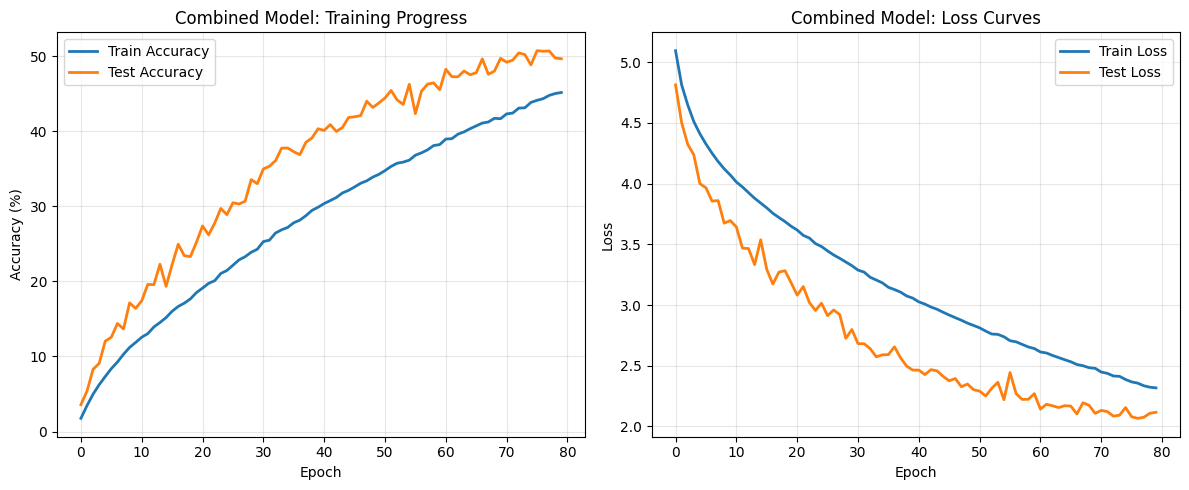

=== 最佳组合模型详细结果 ===
模型名称: Deeper/Wider + Residual
模型参数量: 20.14M
最佳测试准确率: 50.71%
最终训练准确率: 45.15%
最终测试准确率: 49.64%

相比各个单独因子的提升:
  vs Baseline: +19.35%
  vs Residual: +-2.06%
  vs Deeper/Wider: +-2.16%


In [14]:
# 可视化最佳模型的训练过程
plt.figure(figsize=(12, 5))

# 训练和测试准确率
plt.subplot(1, 2, 1)
plt.plot(best_combined_history['train_acc'], label='Train Accuracy', linewidth=2)
plt.plot(best_combined_history['test_acc'], label='Test Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Combined Model: Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# 训练和测试损失
plt.subplot(1, 2, 2)
plt.plot(best_combined_history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(best_combined_history['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Combined Model: Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./figure/tinyimagenet_best_model.png', dpi=150, bbox_inches='tight')
plt.show()

# 打印详细结果
print(f"=== 最佳组合模型详细结果 ===")
print(f"模型名称: Deeper/Wider + Residual")
print(f"模型参数量: {best_model.get_num_params() / 1_000_000:.2f}M")
print(f"最佳测试准确率: {best_combined_acc:.2f}%")
print(f"最终训练准确率: {best_combined_history['train_acc'][-1]:.2f}%")
print(f"最终测试准确率: {best_combined_history['test_acc'][-1]:.2f}%")
print(f"\n相比各个单独因子的提升:")
print(f"  vs Baseline: +{best_combined_acc - all_results['baseline']:.2f}%")
print(f"  vs Residual: +{best_combined_acc - all_results['residual']:.2f}%")
print(f"  vs Deeper/Wider: +{best_combined_acc - all_results['deeper_wider']:.2f}%")


In [12]:
# 创建结果DataFrame
results_data = []
for method, acc in all_results.items():
    results_data.append({
        'Method': method,
        'Accuracy': acc,
        'Improvement': acc - baseline_acc
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("=== Tiny-ImageNet 实验结果汇总 ===")
print(results_df.to_string(index=False))

# 计算各改进因子的贡献
print(f"=== 改进因子贡献分析 ===")
print(f"基线模型准确率: {baseline_acc:.2f}%")
print(f"残差连接提升: {all_results['residual'] - baseline_acc:.2f}%")
print(f"更深更宽网络提升: {all_results['deeper_wider'] - baseline_acc:.2f}%")
print(f"最佳优化器({best_optimizer})提升: {optimizer_results[best_optimizer] - baseline_acc:.2f}%")
print(f"最佳数据增强({best_augmentation})提升: {augmentation_results[best_augmentation] - baseline_acc:.2f}%")
print(f"SE注意力提升: {all_results['se_attention'] - baseline_acc:.2f}%")

=== Tiny-ImageNet 实验结果汇总 ===
       Method  Accuracy  Improvement
 deeper_wider     52.87        21.51
     residual     52.77        21.41
best_combined     50.71        19.35
 se_attention     43.54        12.18
      RMSprop     35.70         4.34
        AdamW     32.51         1.15
     baseline     31.36         0.00
        mixup     30.05        -1.31
       cutmix     23.77        -7.59
=== 改进因子贡献分析 ===
基线模型准确率: 31.36%
残差连接提升: 21.41%
更深更宽网络提升: 21.51%
最佳优化器(RMSprop)提升: 4.34%
最佳数据增强(basic)提升: 0.00%
SE注意力提升: 12.18%


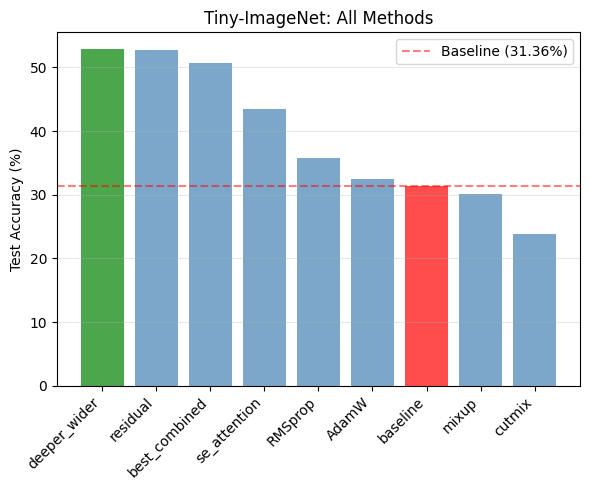

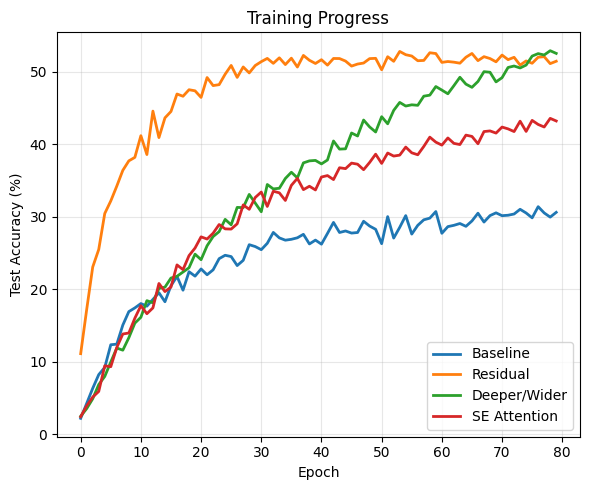

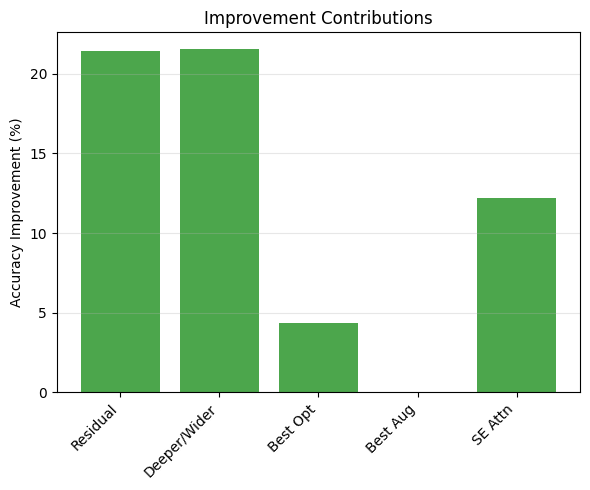

单独结果图已保存为 tinyimagenet_accuracy_comparison.png, tinyimagenet_training_progress.png, tinyimagenet_improvement_contributions.png


In [13]:
# 1. 各方法准确率对比
plt.figure(figsize=(6, 5))
colors = ['red' if method == 'baseline' else 'green' if acc == results_df['Accuracy'].max() else 'steelblue' 
          for method, acc in zip(results_df['Method'], results_df['Accuracy'])]
bars = plt.bar(range(len(results_df)), results_df['Accuracy'], color=colors, alpha=0.7)
plt.xticks(range(len(results_df)), results_df['Method'], rotation=45, ha='right')
plt.ylabel('Test Accuracy (%)')
plt.title('Tiny-ImageNet: All Methods')
plt.axhline(y=baseline_acc, color='red', linestyle='--', alpha=0.5, label=f'Baseline ({baseline_acc:.2f}%)')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./figure/tinyimagenet_accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 2. 训练曲线对比
plt.figure(figsize=(6, 5))
plt.plot(baseline_history['test_acc'], label='Baseline', linewidth=2)
plt.plot(residual_history['test_acc'], label='Residual', linewidth=2)
plt.plot(deeper_history['test_acc'], label='Deeper/Wider', linewidth=2)
plt.plot(se_history['test_acc'], label='SE Attention', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./figure/tinyimagenet_training_progress.png', dpi=150, bbox_inches='tight')
plt.show()

# 3. 改进因子贡献
plt.figure(figsize=(6, 5))
improvements = {
    'Residual': all_results['residual'] - baseline_acc,
    'Deeper/Wider': all_results['deeper_wider'] - baseline_acc,
    f'Best Opt': optimizer_results[best_optimizer] - baseline_acc,
    f'Best Aug': augmentation_results[best_augmentation] - baseline_acc,
    'SE Attn': all_results['se_attention'] - baseline_acc
}
colors_imp = ['green' if v > 0 else 'red' for v in improvements.values()]
plt.bar(improvements.keys(), improvements.values(), color=colors_imp, alpha=0.7)
plt.ylabel('Accuracy Improvement (%)')
plt.title('Improvement Contributions')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./figure/tinyimagenet_improvement_contributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("单独结果图已保存为 tinyimagenet_accuracy_comparison.png, tinyimagenet_training_progress.png, tinyimagenet_improvement_contributions.png")